# 13 - Diferença em Diferenças

## Três Outdoors no Sul do Brasil

Lembro quando trabalhava com marketing, e uma maneira excelente de fazer marketing era por meio de publicidade na internet. Não porque seja muito eficiente (embora seja), mas porque é muito fácil saber se é eficaz ou não. Com o marketing online, você tem uma maneira de saber quais clientes viram o anúncio e pode rastreá-los com cookies para ver se acabaram na sua página de destino ou clicaram em algum botão de download. Você também pode usar aprendizado de máquina para encontrar clientes em potencial muito semelhantes aos seus e apresentar o anúncio apenas pra eles. Nesse sentido, o marketing online é muito preciso: você direciona apenas aqueles que deseja e pode ver se respondem como você gostaria.

Mas nem todos são suscetíveis ao marketing online. Às vezes, é necessário recorrer a técnicas menos precisas, como uma campanha de TV ou a colocação de um outdoor na rua. Geralmente, a diversidade de canais de marketing é algo procurado pelos departamentos de marketing. No entanto, se o marketing online é uma vara de pesca profissional para pegar aquele tipo específico de atum, os outdoors e a TV são redes gigantes lançadas em um cardume de peixes, na esperança de pegar pelo menos alguns grandes. Outro problema com os anúncios em outdoors e na TV é que é muito mais difícil saber o quão eficazes são. Claro, você pode medir o volume de compras, ou o que quer que esteja tentando impulsionar, antes e depois de colocar um outdoor em algum lugar. Se houver um aumento, há alguma evidência de que o marketing é eficaz. Mas como saber se esse aumento não é apenas uma tendência natural no reconhecimento do seu produto? Em outras palavras, como você saberia o contrafactual $Y_0$ do que teria acontecido se você não tivesse colocado os outdoors em primeiro lugar?

![img](./data/img/diff-in-diff/secrets.png)

Uma técnica para responder a esses tipos de perguntas é a Diferença em Diferenças, ou diff-in-diff para os amigos próximos. Diff-in-diff é comumente usado para avaliar o efeito de intervenções macro, como o efeito da imigração no desemprego, o efeito das mudanças nas leis de armas nas taxas de criminalidade ou simplesmente a diferença no envolvimento do usuário devido a uma campanha de marketing. Em todos estes casos, existe um período antes e depois da intervenção e pretende-se desvendar o impacto da intervenção de uma tendência geral. Como exemplo motivador, vejamos uma pergunta semelhante à que tive que responder.

Para descobrir quão eficazes eram os outdoors como canal de marketing, colocamos 3 outdoors na cidade de Porto Alegre, a capital do estado do Rio Grande do Sul. Queríamos ver se isso impulsionaria os depósitos em nossa conta poupança. Como observação para aqueles que não estão muito familiarizados com a geografia brasileira, o Rio Grande do Sul faz parte do sul do país, uma das regiões mais desenvolvidas.

Tendo isso em mente, decidimos também analisar dados de outra capital do sul, Florianópolis, a capital do estado de Santa Catarina. A ideia é que poderíamos usar Florianópolis como uma amostra de controle para estimar o contrafactual $Y_0$ em comparação com Porto Alegre (aliás, isso não foi o experimento real, que é confidencial, mas a ideia é muito semelhante). Colocamos o outdoor em Porto Alegre durante todo o mês de junho. Os dados que temos são parecidos com estes:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

deposits  poa  jul
0        42    1    0
1         0    1    0
2        52    1    0
3       119    1    0
4        21    1    0

Lembre-se de que os depósitos são nossa variável de resultado, aquela que desejamos aumentar com os outdoors. POA é um indicador dummy para a cidade de Porto Alegre. Quando é zero, significa que as amostras são de Florianópolis. Jul é uma dummy para o mês de julho, ou para o período pós-intervenção. Quando é zero, refere-se a amostras de maio, o período pré-intervenção.

## Estimador DID

Para evitar confusão entre Tempo e Tratamento, a partir de agora, usarei D para denotar tratamento e T para denotar tempo. Seja $Y_D(T)$ o resultado potencial para o tratamento D no período T. Em um mundo ideal em que temos a capacidade de observar o contrafactual, estimaríamos o efeito do tratamento de uma intervenção da seguinte forma:

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

Em palavras, o efeito causal é o resultado no período pós-intervenção no caso de um tratamento, menos o resultado também no período pós-intervenção, mas no caso de ausência de tratamento. Claro, não podemos medir isso porque $Y_0(1)$ é contrafactual.

Uma maneira de contornar isso é uma comparação antes e depois.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

Em nosso exemplo, compararíamos os depósitos médios de POA antes e depois do outdoor ser colocado.

In [3]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

Este estimador nos diz que devemos esperar um aumento de R$ 41,04 nos depósitos após a intervenção. Mas podemos confiar nisso?

Observe que $E[Y(0)|D=1]=E[Y_0(0)|D=1]$, ou seja, o resultado observado para a unidade tratada **antes da intervenção** é igual ao resultado contrafactual para a unidade tratada também antes da intervenção. Como estamos usando isso para estimar o contrafactual **após a intervenção** $E[Y_0(1)|D=1]$, essa estimativa acima pressupõe que $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$.

Isso nos diz que, no caso de nenhuma intervenção, o resultado no período posterior seria o mesmo que o resultado do período inicial. Isso seria claramente falso se a sua variável de resultado seguir algum tipo de tendência. Por exemplo, se os depósitos estiverem aumentando em POA, $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, ou seja, o resultado do período posterior seria maior do que o do período inicial, mesmo na ausência da intervenção. Com um argumento semelhante, se a tendência em Y estiver diminuindo, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. Isso é para mostrar que essa comparação antes e depois não é um ótimo estimador.

Outra ideia é comparar o grupo tratado com um grupo não tratado que não recebeu a intervenção:

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

Em nosso exemplo, seria comparar os depósitos de POA com os de Florianópolis no período pós-intervenção.

In [4]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

Esse estimador está nos dizendo que a campanha é prejudicial e que os clientes irão diminuir os depósitos em R$ 119,10.

Observe que $E[Y(1)|D=0]=E[Y_0(1)|D=0]$. E, como estamos usando $E[Y(1)|D=0]$ para estimar o contrafactual para os tratados após a intervenção, estamos assumindo que podemos substituir o contrafactual ausente da seguinte forma: $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$. Mas observe que isso só seria verdade se ambos os grupos tivessem um nível inicial muito semelhante. Por exemplo, se Florianópolis tiver muito mais depósitos do que Porto Alegre, isso não seria verdade porque $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. Por outro lado, se o nível de depósitos for menor em Florianópolis, teríamos $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$.

Novamente, esta não é uma boa ideia. Para resolver isso, podemos usar tanto a comparação espacial quanto a temporal. Essa é a ideia da abordagem de diferença em diferenças. Funciona substituindo o contrafactual ausente da seguinte maneira:

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

O que isso faz é pegar a unidade tratada **antes da intervenção** e adicionar um componente de tendência a ela, que é estimado usando o controle $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$. Em outras palavras, está dizendo que a unidade tratada **após a intervenção**, se não tivesse sido tratada, se pareceria com a **tratada antes do tratamento** mais um fator de crescimento que é o mesmo que o crescimento do controle.

É importante notar que isso pressupõe que as tendências no tratamento e no controle são as mesmas:

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

onde o lado esquerdo é a tendência contrafactual. Agora, podemos substituir o contrafactual estimado na definição do efeito do tratamento $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

Se reorganizarmos os termos, obtemos o estimador clássico Diff-in-Diff.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

Ele recebe esse nome porque calcula a diferença entre a diferença entre tratamento e controle depois e antes do tratamento.

Aqui está como isso se parece em código.

In [5]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

O Diff-in-Diff está nos dizendo que devemos esperar um aumento dos depósitos em R$ 6,52 por cliente. Observe que a suposição que o diff-in-diff faz é muito mais plausível do que os outros 2 estimadores. Ele apenas pressupõe que o padrão de crescimento entre as duas cidades é o mesmo. Mas não exige que elas tenham o mesmo nível base, nem exige que a tendência seja zero.

Para visualizar o que o Diff-in-Diff está fazendo, podemos projetar a tendência de crescimento do não tratado no tratado para ver o contrafactual, ou seja, o número de depósitos que deveríamos esperar se não houvesse intervenção.

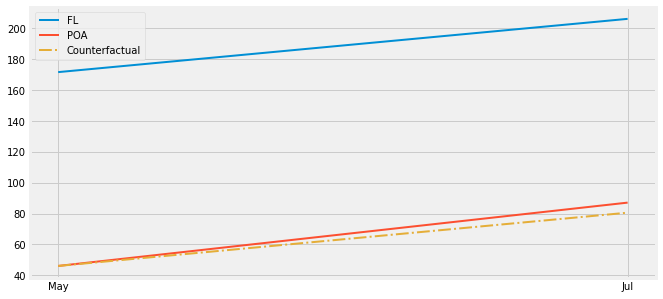

In [6]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

Note a pequena diferença entre as linhas tracejadas vermelha e amarela? Se você realmente focar, poderá ver o pequeno efeito do tratamento em Porto Alegre.

![img](./data/img/diff-in-diff/cant-read.png)


Agora, você pode estar se perguntando "quanto posso confiar neste estimador? É meu direito que os erros padrão sejam relatados para mim!". O que faz sentido, já que estimadores sem eles parecem bobos. Para fazer isso, usaremos um truque interessante que envolve regressão. Especificamente, vamos estimar o seguinte modelo linear:

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

Observe que $\beta_0$ é a linha de base do controle. Em nosso caso, é o nível de depósitos em Florianópolis no mês de maio. Se ligarmos o indicador para a cidade tratada, obtemos $\beta_1$. Portanto, $\beta_0 + \beta_1$ é a linha de base de Porto Alegre em maio, antes da intervenção, e $\beta_1$ é o aumento na linha de base de Porto Alegre em relação a Florianópolis. Se desligarmos o indicador para POA e ligarmos o indicador para julho, obtemos $\beta_0 + \beta_2$, que é o nível de Florianópolis em julho, após o período de intervenção. $\beta_2$ é então a tendência do controle, já que a adicionamos à linha de base para obter o nível do controle no período pós-intervenção. Em resumo, $\beta_1$ é o incremento que obtemos ao passar do controle para o tratado, $\beta_2$ é o incremento que obtemos ao passar do período anterior para o período posterior à intervenção. Finalmente, se ligarmos ambos os indicadores, obtemos $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ é o nível em Porto Alegre após a intervenção. Portanto, $\beta_3$ é o impacto incremental ao passar de maio para julho e de Florianópolis para POA. Em outras palavras, é o estimador Diff-in-Diff.

Se você não acredita em mim, verifique por si mesmo. Você deve obter exatamente o mesmo número que obtivemos acima. E observe também como obtemos nossos tão desejados erros padrão.

In [7]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

## Tendências Não Paralelas

Um problema óbvio com o Diff-in-Diff é a falha em satisfazer a suposição de tendências paralelas. Se a tendência de crescimento do tratado for diferente da tendência do controle, o diff-in-diff será enviesado. Este é um problema comum em dados não aleatórios, onde a decisão de tratar uma região é baseada em seu potencial de responder bem ao tratamento, ou quando o tratamento é direcionado a regiões que não estão se saindo muito bem. Pegue nosso exemplo de marketing. Decidimos testar outdoors em Porto Alegre não para verificar o efeito de outdoors em geral. A razão é simplesmente porque as vendas têm um desempenho ruim lá. Talvez o marketing online não esteja funcionando lá. Neste caso, poderia ser que o crescimento que veríamos em Porto Alegre sem um outdoor seria menor do que o crescimento que observamos em outras cidades. Isso nos levaria a subestimar o efeito do outdoor lá.

Uma maneira de verificar se isso está acontecendo é plotar a tendência usando períodos anteriores. Por exemplo, suponha que POA tenha uma pequena tendência decrescente, mas Florianópolis esteja em uma ascensão acentuada. Nesse caso, mostrar períodos anteriores revelaria essas tendências e saberíamos que Diff-in-Diff não é um estimador confiável.

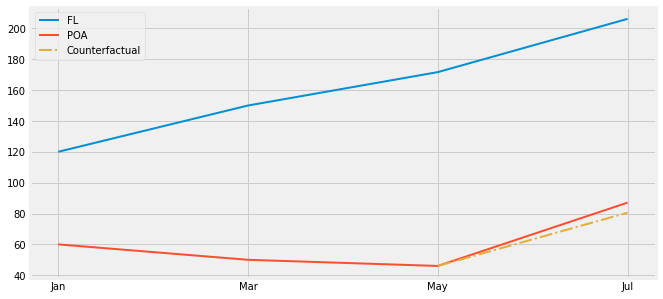

In [18]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

Veremos como resolver esse problema com o método de controle sintético. Ele usará várias cidades para criar uma cidade sintética que segue de perto a tendência da cidade de interesse. Mas, por enquanto, lembre-se de que você sempre precisa verificar se há tendências paralelas ao aplicar o Diff-in-Diff.

![img](./data/img/diff-in-diff/non-parallel.png)

Uma questão final que vale a pena mencionar é que você não conseguirá colocar intervalos de confiança em torno do seu estimador Diff-in-Diff se tiver apenas dados agregados. Digamos, por exemplo, que você não tenha dados sobre o que cada um de nossos clientes de Florianópolis ou Porto Alegre fez. Em vez disso, você só tem os depósitos médios antes e depois da intervenção para ambas as cidades. Nesse caso, você ainda será capaz de estimar o efeito causal pelo Diff-in-Diff, mas não saberá a variância. Isso porque toda a variabilidade nos seus dados foi espremida na agregação.

## Conceitos-chave

Exploramos uma técnica amplamente aplicada quando estamos estimando efeitos causais em entidades mais macro (escolas, cidades, estados, países...). Diferença em Diferenças pega uma unidade tratada antes e depois do tratamento e compara a tendência no resultado com a de uma unidade de controle. Aqui, vimos como isso poderia ser aplicado para estimar o efeito de uma campanha de marketing específica para uma cidade.

Finalmente, observamos como o Diff-in-Diff falha se a tendência entre a unidade tratada e a de controle não for a mesma. Também vimos como o diff-in-diff será problemático se tivermos apenas dados agregados.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<div align="center">
<a href="12-Doubly-Robust-Estimation.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="14-Panel-Data-and-Fixed-Effects.ipynb">Próximo --></a>  
</div>